In [1]:
from os import listdir
from xml.dom.minidom import parse

import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
import string

# import nltk CoreNLP module (just once)
from nltk.parse.corenlp import CoreNLPDependencyParser
# connect to your CoreNLP server (just once)
corenlp_parser = CoreNLPDependencyParser(url="http://localhost:9000")

# Data analysis
Examine (by hand or collecting simple statistics) the train
dataset and try to infer general rules that are right in most
cases, even if they seldom apply (high precision, low recall

In [2]:
def get_offsets(word, s):
    '''
    Task:
        Given a word and sentence, returns its starting end ending index in the sentence.
    
    Input:
        word: word to find offsets for
        s: sentence containing the word
    
    Output:
        Returns a tuple containing the start and end offset.
    '''
    start = s.find(word)
    end = start + len(word) - 1
    return start, end

def analyze(s):
    '''
    Task:
        Given one sentence, sends it to CoreNLP to obtain the tokens, tags,
        and dependency tree. It also adds the start/end offsets to each token.
    
    Input:
        s: string containing the text for one sentence
    
    Output:
        Returns the nltk DependencyGraph object produced by CoreNLP, enriched with token offsets.

    '''
    s = s.replace("%", "<percentage>")
    tree, = corenlp_parser.raw_parse(s)
    for n in tree.nodes.items():
        node = n[1]
        if node['word']:
            start, end = get_offsets(node['word'], s)
            node['start'] = start
            node['end'] = end
            
    return tree

In [3]:
# tree = analyze("Interaction between oxytocin and antidiuretic hormone and its effect on the milk secretion by alveoli of the mammary gland of lactating rats.")
# print(tree.nodes.items())
s2 = "Co-administration of oral ketoconazole 200 mg twice daily increased retapamulin geometric mean AUC(0-24) and Cmax by 81% after topical application of retapamulin ointment, 1% on the abraded skin of healthy adult males. "
tree = analyze(s2)
print(tree.tree())

(Co-administration
  (ketoconazole of oral)
  (AUC
    (mg 200)
    (increased (daily twice))
    retapamulin
    geometric
    mean
    (24 ( 0 - ))
    (Cmax and (81 by))
    (<percentage>
      (application
        after
        topical
        (ointment of retapamulin)
        ,
        (<percentage>
          1
          (skin on the abraded (males of healthy adult))))))
  .)


In [4]:
#for n in tree.nodes.items():
#    node = n[1]
#    print(node)

***

In [3]:
datadir = "../../labAHLT/data/train"
entities = {}
_pairs = []
pairs = []
analyses = []
sentences = []


for f in listdir(datadir):

    tree = parse(datadir + "/" + f)

    sents = tree.getElementsByTagName("sentence")
    for s in sents:

        sid = s.attributes["id"].value # get sentence id
        stext = s.attributes["text"].value # get sentence text
        
        
        if len(stext) == 0:
            continue
            
        sentences.append(s)
        
        ents = s.getElementsByTagName("entity")
        for e in ents:
            eid = e.attributes["id"].value
            entities[eid] = e.attributes["text"].value
        
        # Tokenize, tag, and parse sentence
        analysis = analyze(stext)
        analyses.append(analysis)

        # for each pair in the sentence , decide whether it is DDI and its type
        prs = s.getElementsByTagName("pair")
        temp_pairs = []
        for p in prs:
            id_e1 = p.attributes["e1"].value
            id_e2 = p.attributes["e2"].value
            interaction = p.attributes["type"].value if p.attributes["ddi"].value == "true" else None
            temp_pairs.append({"e1": id_e1, "e2": id_e2, "sid": sid, "interaction": interaction})
#             ddi_type = check_interaction(analysis, entities , id_e1 , id_e2)
#            if ddi_type != None:
#                print(sid +"|"+ id_e1 +"|"+ id_e2 +"|"+ ddi_type,file = outf)
#            if p.attributes["ddi"].value == "true":
#                print(sid +"|"+ id_e1 +"|"+ id_e2 +"|"+ interaction)
        pairs.append(temp_pairs)

In [4]:
def find_entity_in_tree(entity, tree):
    for n in tree.nodes.items():
        node = n[1]
        if node["word"] and entity.find(node["word"]) >= 0:
            return node
        
    # PROBLEM: TWO_WORD ENTITIES!!! How to find the relevant nodes??? 
    return None

def analyze_interactions_train(analysis, entities, e1, e2):
    tree = analysis.tree()
    
    entity1 = entities[e1]
    entity2 = entities[e2]
    
#     print(entity1)
#     print(entity2)
    
    e1_node = find_entity_in_tree(entity1, analysis)
    e2_node = find_entity_in_tree(entity2, analysis)
           
    e1_tag = e1_node['tag'] if e1_node else None
    e2_tag = e2_node['tag'] if e2_node else None
    
    #TODO  -return more, such as the relationship between e1 and e2 in the tree
    e1_addr =  e1_node['address'] if e1_node else 0
    e2_addr = e2_node['address'] if e2_node else 0  
    
    # TODO - perhaps getting the Tag of the head would be useful too
    # HEAD ANALYSIS
    h_e1 = e1_node['head'] if e1_node else None      #position of the head
    head_e1 = analysis.nodes[h_e1]['lemma'] if e1_node else None
    tag_head_e1 = analysis.nodes[h_e1]['tag'][0].lower() if e1_node else None
    
    h_e2 = e2_node['head'] if e2_node else None      #position of the head
    head_e2 = analysis.nodes[h_e2]['lemma'] if e2_node else None
    tag_head_e2 = analysis.nodes[h_e2]['tag'][0].lower() if e2_node else None
    
    if head_e1 == head_e2 and tag_head_e1 == 'v' and tag_head_e2 == 'v':
        under_same_verb = True
    else:
        under_same_verb = False
        
    if head_e1 == head_e2 and head_e1 != None and head_e2 != None:
        under_same_word = True
    else:
        under_same_word = False
    
    if head_e1 == entity2 and head_e1 != None:
        e1_under_e2 = True
    else: 
        e1_under_e2 = False
    
    if head_e2 == entity1 and head_e2 != None:
        e2_under_e1 = True
    else:
        e2_under_e1 = False


    return  e1_tag, e2_tag, e2_addr - e1_addr, head_e1, head_e2, under_same_verb, under_same_word, e1_under_e2, e2_under_e1

In [5]:
#print(pairs[0])
#print(analyses[0])
#print(entities)

In [6]:
for i, pair_list in enumerate(pairs):
    analysis = analyses[i]
    for pair in pair_list:
        e1_tag, e2_tag, address_difference, e1_h, e2_h, u_s_v, u_s_w, e1_e2, e2_e1 = analyze_interactions_train(analysis, entities, pair['e1'], pair['e2'])
        pair['e1_tag'] = e1_tag
        pair['e2_tag'] = e2_tag
        pair['address_difference'] = address_difference
        pair['head_e1'] = e1_h
        pair['head_e2'] = e2_h
        pair['under_same_verb'] = u_s_v
        pair['under_same_word'] = u_s_w
        pair['e1_under_e2'] = e1_e2
        pair['e2_under_e1'] = e2_e1
        
temp_pairs = [item for sublist in pairs for item in sublist]
df = pd.DataFrame(temp_pairs)
df.head()

,e1,e2,sid,interaction,e1_tag,e2_tag,address_difference,head_e1,head_e2,under_same_verb,under_same_word,e1_under_e2,e2_under_e1
0,DDI-DrugBank.d481.s0.e0,DDI-DrugBank.d481.s0.e1,DDI-DrugBank.d481.s0,mechanism,NN,NNP,11,rich,absorption,False,False,False,False
1,DDI-DrugBank.d10.s1.e0,DDI-DrugBank.d10.s1.e1,DDI-DrugBank.d10.s1,None,NN,NN,2,treatment,corticosteroid,False,False,False,True
2,DDI-DrugBank.d10.s1.e0,DDI-DrugBank.d10.s1.e2,DDI-DrugBank.d10.s1,None,NN,NNP,24,treatment,receive,False,False,False,False
3,DDI-DrugBank.d10.s1.e1,DDI-DrugBank.d10.s1.e2,DDI-DrugBank.d10.s1,None,NN,NNP,22,corticosteroid,receive,False,False,False,False
4,DDI-DrugBank.d10.s2.e0,DDI-DrugBank.d10.s2.e1,DDI-DrugBank.d10.s2,mechanism,NNP,DT,7,administration,range,False,False,False,False


***

**Example of rules:** 
- Check whether one entity is inside the subject of one verb, and the other is inside the direct object of the same verb. If that is the case, the lemma of the verb decides which is the type of interaction (checking lists of frequent verbs for each interaction type. The lists contain between 3 and 10 verbs, depending on the class).
- If the previous rule is not satisfied, the first verb found between both entities that belongs to one of the lists decides the interaction type. 
- If no such verb is found, the type is None. 

In [27]:
# Verb lists could be obtained from here
df['head_e1'].loc[df['interaction'] == 'mechanism'].value_counts()
df['head_e1'].loc[df['interaction'] == 'effect'].value_counts()
df['head_e1'].loc[df['interaction'] == 'int'].value_counts()
df['head_e1'].loc[df['interaction'] == 'advise'].value_counts()

administer           81
use                  70
co-administration    40
administration       39
dose                 21
                     ..
prescribe             1
releaser              1
overdose              1
midazolam             1
interrupt             1
Name: head_e1, Length: 157, dtype: int64

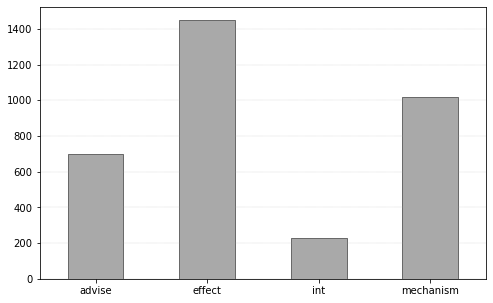

In [8]:
#df['interaction'].unique()
df_advise = df.loc[df['interaction']=='advise']
df_effect = df.loc[df['interaction']=='effect']
df_int = df.loc[df['interaction']=='int']
df_mechanism = df.loc[df['interaction']=='mechanism']

advise_count = df_advise.shape[0]
effect_count = df_effect.shape[0]
int_count = df_int.shape[0]
mechanism_count = df_mechanism.shape[0]

interaction_counts = pd.DataFrame(df.groupby('interaction').count()['e1'])
ax = interaction_counts.plot.bar(figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

In [9]:
df_int.head()

,e1,e2,sid,interaction,e1_tag,e2_tag,address_difference,head_e1,head_e2,under_same_verb,under_same_word,e1_under_e2,e2_under_e1
201,DDI-DrugBank.d187.s8.e1,DDI-DrugBank.d187.s8.e2,DDI-DrugBank.d187.s8,int,NNP,NNP,7,None,Ketoconazole,False,False,False,True
349,DDI-DrugBank.d5.s3.e0,DDI-DrugBank.d5.s3.e1,DDI-DrugBank.d5.s3,int,NNP,DT,-4,interaction,interaction,False,True,False,False
350,DDI-DrugBank.d5.s3.e0,DDI-DrugBank.d5.s3.e2,DDI-DrugBank.d5.s3,int,NNP,DT,-4,interaction,interaction,False,True,False,False
1316,DDI-DrugBank.d13.s0.e0,DDI-DrugBank.d13.s0.e1,DDI-DrugBank.d13.s0,int,NNP,NNS,10,interact,interact,True,True,False,False
1317,DDI-DrugBank.d13.s0.e0,DDI-DrugBank.d13.s0.e2,DDI-DrugBank.d13.s0,int,NNP,NN,12,interact,inhibitor,False,False,False,False


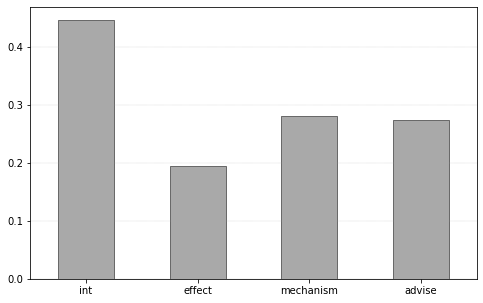

In [10]:
# e1 is an NNP
df1 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e1_tag']=='NNP'].count()[0]/int_count,
                                                                            df_effect.loc[df['e1_tag']=='NNP'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e1_tag']=='NNP'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e1_tag']=='NNP'].count()[0]/advise_count]})

ax = df1.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

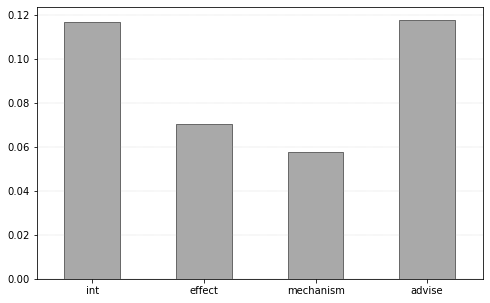

In [11]:
# e2 is an NNP
df2 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e2_tag']=='NNP'].count()[0]/int_count,
                                                                            df_effect.loc[df['e2_tag']=='NNP'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e2_tag']=='NNP'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e2_tag']=='NNP'].count()[0]/advise_count]})

ax = df2.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

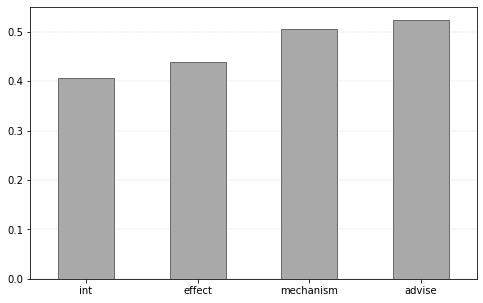

In [12]:
# e1 is an NN
df1 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e1_tag']=='NN'].count()[0]/int_count,
                                                                            df_effect.loc[df['e1_tag']=='NN'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e1_tag']=='NN'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e1_tag']=='NN'].count()[0]/advise_count]})

ax = df1.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

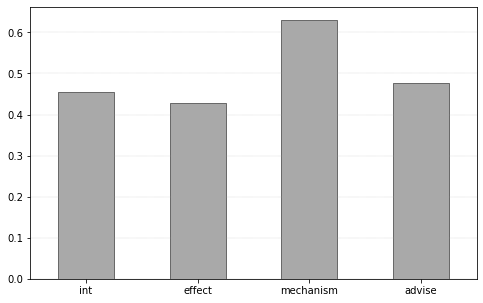

In [13]:
# e2 is an NN
df2 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e2_tag']=='NN'].count()[0]/int_count,
                                                                            df_effect.loc[df['e2_tag']=='NN'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e2_tag']=='NN'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e2_tag']=='NN'].count()[0]/advise_count]})

ax = df2.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

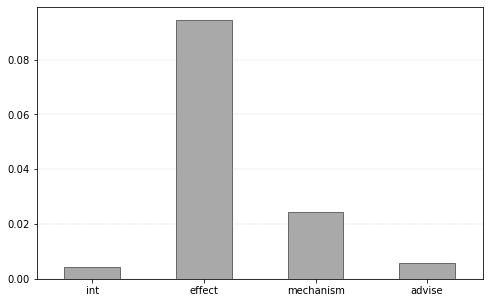

In [14]:
# e1 is a JJ
df2 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e1_tag']=='JJ'].count()[0]/int_count,
                                                                            df_effect.loc[df['e1_tag']=='JJ'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e1_tag']=='JJ'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e1_tag']=='JJ'].count()[0]/advise_count]})

ax = df2.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

####!!!! GOOD

In [ ]:
## GOOD HEURISTIC!!!
# if e1 is a JJ, there is an effect

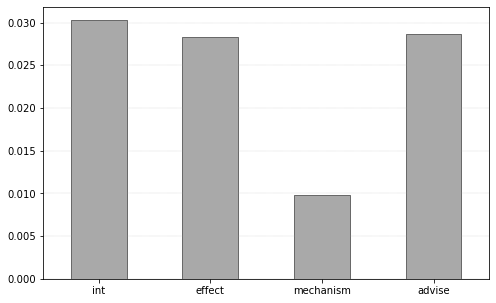

In [15]:
# e2 is a JJ
df2 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e2_tag']=='JJ'].count()[0]/int_count,
                                                                            df_effect.loc[df['e2_tag']=='JJ'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e2_tag']=='JJ'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e2_tag']=='JJ'].count()[0]/advise_count]})

ax = df2.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

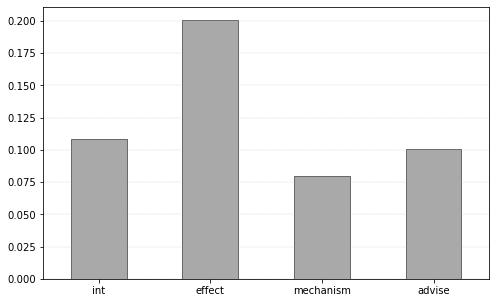

In [16]:
# e1 is an NNS
df1 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e1_tag']=='NNS'].count()[0]/int_count,
                                                                            df_effect.loc[df['e1_tag']=='NNS'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e1_tag']=='NNS'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e1_tag']=='NNS'].count()[0]/advise_count]})

ax = df1.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

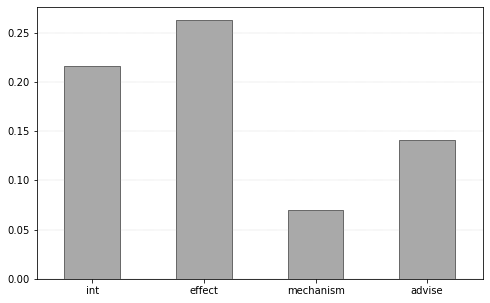

In [17]:
# e2 is an NNS
df2 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e2_tag']=='NNS'].count()[0]/int_count,
                                                                            df_effect.loc[df['e2_tag']=='NNS'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e2_tag']=='NNS'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e2_tag']=='NNS'].count()[0]/advise_count]})

ax = df2.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)


22.17748917748918


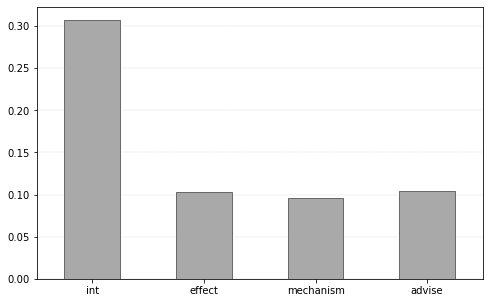

In [18]:
print()
print(df_int['address_difference'].mean())

df['address_difference'] > 15

df1 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['address_difference'] > 25].count()[0]/int_count,
                                                                            df_effect.loc[df['address_difference'] > 25].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['address_difference'] > 25].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['address_difference'] > 25].count()[0]/advise_count]})


ax = df1.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

***
### Sentence Analysis

Instructor's example: 
- Pairs with an interaction of type _<font color=blue>effect</font>_ often have clue words like <font color=blue>administer, potentiate, prevent, </font> etc. between e1 and e2
- Pairs with ann interaction of type _<font color=blue>mechanism</font>_ often have clue words like _<font color=blue>reduce, increase, decrease,</font>_ etc. between e1 and e2. 
- Pairs with ann interaction of type _<font color=blue>int</font>_ often have clue words like _<font color=blue>interact, interaction,</font>_ etc. between e1 and e2. 
Better results may be achieved if properties of the dependency tree are used (e.g. e1 is _<font color=red>under</font>_ e2, both e1 and e2 are _<font color=red>under</font>_ the same verb, e1 is _<font color=red>under</font>_ the subject of certain verbs (*enhance*, *reduce*, ...), etc.)

In [8]:
# Get Words between entities e1 and e2 in sentence
# Get Words outside subsentence delimited by e1-e2
dict_sentences = {}
lst = []
for s in sentences:
    sid = s.attributes["id"].value
    stext = s.attributes["text"].value
    dict_sentences[sid] = stext
#print(dict_sentences)

In [11]:
def get_positions(analysis, entities, e1, e2):
    tree = analysis.tree()
    
    entity1 = entities[e1]
    entity2 = entities[e2]
    
    e1_node = find_entity_in_tree(entity1, analysis)
    e2_node = find_entity_in_tree(entity2, analysis)
           
    e1_start =  e1_node['start'] if e1_node else 0
    e1_end = e1_node['end'] if e2_node else 0  
    
    e2_start =  e2_node['start'] if e1_node else 0
    e2_end = e2_node['end'] if e2_node else 0  


    return e1_start, e1_end, e2_start, e2_end

def dict_add_one(dictionary, key):
    if key in dictionary:
        dictionary[key] += 1
    else:
        dictionary[key] = 1

In [45]:
word_dict = {'effect': 
                    {'clue_words':{},
                     'outside_words':{},
                     'sentence_words':{}
                    },
                 'mechanism':
                    {'clue_words':{},
                     'outside_words':{},
                     'sentence_words':{}
                    },
                 'int':
                    {'clue_words':{},
                     'outside_words':{},
                     'sentence_words':{}
                    },
                 'advise':
                    {'clue_words':{},
                     'outside_words':{},
                     'sentence_words':{}
                    },
                }

# Code should need improvement, there are pairs that throw error 
# Filtering words by verb should be better
for i, pair_list in enumerate(pairs):
    analysis = analyses[i]
    try:
        for pair in pair_list:
            start_e1, end_e1, start_e2, end_e2 = get_positions(analysis, entities, pair['e1'], pair['e2'])
            sid = pair_list[0]['sid']
        interaction = pair_list[0]['interaction']
        sentence = dict_sentences[sid]
    except:
        continue
    
    if interaction in ['effect', 'mechanism','int','advise']:
        between_entities = [word for word in word_tokenize(stext[end_e1+1:start_e2]) if word not in stopwords and word not in string.punctuation]
        for word in between_entities:
            dict_add_one(word_dict[interaction]['clue_words'], word) 

        not_between = [word for word in word_tokenize(stext[:start_e1] + ' ' + stext[end_e2+1:]) if word not in stopwords and word not in string.punctuation]
        for word in not_between:
            dict_add_one(word_dict[interaction]['outside_words'], word) 

        full_sentence = [word for word in word_tokenize(stext[::1]) if word not in stopwords and word not in string.punctuation]
        for word in full_sentence:
            dict_add_one(word_dict[interaction]['sentence_words'], word) 
    
    #break

In [54]:
for i in ['effect', 'mechanism', 'int', 'advise']:
    print("Interaction: ", i)
    print("---Clue_words---")
    print(sorted(word_dict[i]['clue_words'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n ---Outside e1-e2 interval---")
    print(sorted(word_dict[i]['outside_words'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n --Words in sentence--")
    print(sorted(word_dict[i]['sentence_words'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print('---------------------------------------------------------------------------------------------')

Interaction:  effect
---Clue_words---
[('CNS', 360), ('nervous', 351), ('central', 327), ('system', 315), ('especially', 303), ('medications', 276), ('depressants', 246), ('addictive', 222), ('habituating', 201), ('potential', 147), ('prolonged', 108), ('concurrent', 93), ('use', 90), ('may', 78), ('increase', 69), ('risk', 48), ('interact', 36), ('ct', 33), ('act', 33), ('habituation', 30)]

 ---Outside e1-e2 interval---
[('CNS', 3522), ('medications', 3486), ('increase', 2556), ('may', 2553), ('use', 2544), ('concurrent', 2508), ('effects', 1317), ('either', 1317), ('depressant', 1314), ('ethinamate', 1314), ('depression', 1308), ('producing', 1308), ('alcohol', 1299), ('habituation', 1281), ('risk', 1278), ('prolonged', 1146), ('May', 1128), ('potential', 1080), ('interact', 1023), ('habituating', 987)]

 --Words in sentence--
[('CNS', 3934), ('medications', 3894), ('use', 2638), ('may', 2637), ('increase', 2635), ('concurrent', 2627), ('depressant', 1324), ('risk', 1322), ('depress

# trying things

In [56]:
df = pd.DataFrame(_pairs)
df.head(10)

""


In [8]:


interaction_counts = pd.DataFrame(df.groupby('interaction').count()['e1'])
interaction_counts

,e1
interaction,
advise,697
effect,1450
int,231
mechanism,1020


Text(0.5, 0, '')

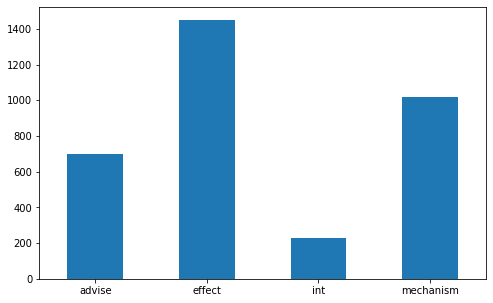

In [9]:
ax = interaction_counts.plot.bar(figsize = (8,5), rot=0, legend = False)
ax.set_xlabel("")

In [24]:
df_advise = df.loc[df['interaction']=='advise']
df_effect = df.loc[df['interaction']=='effect']
df_int = df.loc[df['interaction']=='int']
df_mechanism = df.loc[df['interaction']=='mechanism']



In [45]:
advise_counts_e1 = pd.DataFrame({'Count': df_advise['e1'].value_counts()})
print(advise_counts_e1.head(10))
advise_counts_e2 = pd.DataFrame({'Count': df_advise['e2'].value_counts()})
print(advise_counts_e2.head(10))

advise_counts = pd.concat([advise_counts_e1, advise_counts_e2])
advise_counts = advise_counts.groupby(advise_counts.index).sum().sort_values(by="Count", ascending=False)
print(advise_counts.head(10))

              Count
bupropion        16
TARCEVA          14
glimepiride      12
Duloxetine       11
NSAIDs           11
paricalcitol     11
ZEBETA           10
alosetron         9
VISTIDE           9
BREVIBLOC         8
                           Count
SPRYCEL                       18
ketoconazole                  17
warfarin                      13
tricyclic antidepressants     12
itraconazole                   9
DETROL LA                      9
FACTIVE                        9
Aprepitant                     8
Levo-Dromoran                  7
lithium                        7
                           Count
ketoconazole                  23
tricyclic antidepressants     20
SPRYCEL                       19
bupropion                     16
Aprepitant                    16
warfarin                      16
NSAIDs                        14
TARCEVA                       14
glimepiride                   12
sumatriptan                   12


In [44]:
effect_counts_e1 = pd.DataFrame({'Count': df_effect['e1'].value_counts()})
effect_counts_e2 = pd.DataFrame({'Count': df_effect['e2'].value_counts()})
print(effect_counts_e1.head(10))
print(effect_counts_e2.head(10))
effect_counts = pd.concat([effect_counts_e1, effect_counts_e2])
effect_counts = effect_counts.groupby(effect_counts.index).sum().sort_values(by="Count", ascending=False)
print(effect_counts.head(10))

                           Count
anticoagulant                 79
benzodiazepines               24
phenytoin                     20
sulfonylureas                 18
NIMBEX                        16
NUROMAX                       16
NSAIDs                        15
nondepolarizing agents        15
tricyclic antidepressants     14
Levo-Dromoran                 12
                              Count
alcohol                          38
warfarin                         28
barbiturates                     21
anticoagulants                   19
insulin                          16
antihistamines                   16
tricyclic antidepressants        16
morphine                         16
monoamine oxidase inhibitors     15
CNS depressants                  14
                              Count
anticoagulant                    80
alcohol                          44
warfarin                         32
tricyclic antidepressants        30
benzodiazepines                  30
phenytoin                

In [41]:
mechanism_counts_e1 = pd.DataFrame({'Count': df_mechanism['e1'].value_counts()})
mechanism_counts_e2 = pd.DataFrame({'Count': df_mechanism['e2'].value_counts()})
print(mechanism_counts_e1.head(10))
print(mechanism_counts_e2.head(10))
mechanism_counts = pd.concat([mechanism_counts_e1, mechanism_counts_e2])
mechanism_counts = mechanism_counts.groupby(mechanism_counts.index).sum().sort_values(by="Count", ascending=False)
print(mechanism_counts.head(10))

                Count
EQUETROTM          83
phenytoin          47
ketoconazole       21
Probenecid         19
Cholestyramine     18
rifampin           17
Aprepitant         16
cimetidine         16
azithromycin       15
phenobarbital      12
                 Count
phenytoin           31
ketoconazole        22
midazolam           19
corticosteroids     19
cimetidine          17
digoxin             16
warfarin            15
theophylline        14
methotrexate        13
phenobarbital       12
               Count
EQUETROTM         83
phenytoin         78
ketoconazole      43
cimetidine        33
rifampin          25
phenobarbital     24
digoxin           23
carbamazepine     22
midazolam         22
theophylline      19


In [43]:
int_counts_e1 = pd.DataFrame({'Count': df_int['e1'].value_counts()})
int_counts_e2 = pd.DataFrame({'Count': df_int['e2'].value_counts()})

print(int_counts_e1.head(10))
print(int_counts_e2.head(10))

int_counts = pd.concat([int_counts_e1, int_counts_e2])
int_counts = int_counts.groupby(int_counts.index).sum().sort_values(by="Count", ascending=False)
print(int_counts.head(10))

                        Count
Etonogestrel               44
Methscopolamine            21
nondepolarizing agents     14
MIVACRON                   14
Bentiromide                14
alprazolam                 12
erythromycin               11
Benzthiazide                8
Melatonin                   8
Barbiturates                7
                Count
cyclosporine        5
MAO inhibitors      4
TCA                 4
antibiotics         4
quinidine           4
procainamide        3
alcohol             3
NSAIDs              3
anesthetics         3
lithium             3
                        Count
Etonogestrel               44
Methscopolamine            21
nondepolarizing agents     14
Bentiromide                14
MIVACRON                   14
alprazolam                 13
erythromycin               12
Benzthiazide                8
Melatonin                   8
Barbiturates                7


##  Checking both entities

Text(0.5, 0, '')

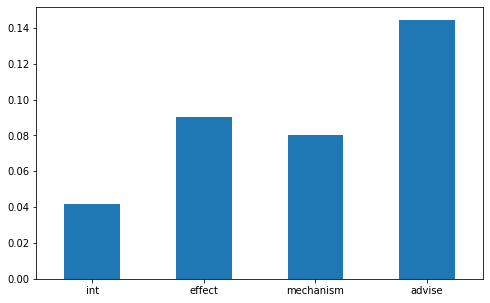

In [50]:
# one of the entities is uppercase
df1 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [int_counts.index.str.isupper().sum()/int_counts.shape[0],
                                                                            effect_counts.index.str.isupper().sum()/effect_counts.shape[0],
                                                                            mechanism_counts.index.str.isupper().sum()/mechanism_counts.shape[0],
                                                                            advise_counts.index.str.isupper().sum()/advise_counts.shape[0]]})

ax = df1.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False)
ax.set_xlabel("")

Text(0.5, 0, '')

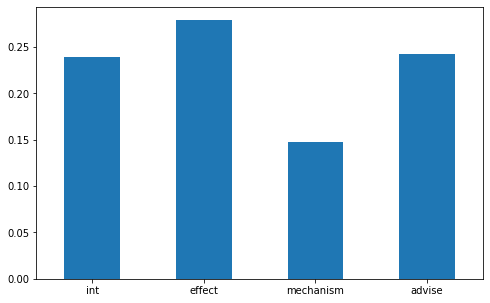

In [54]:
# one of the entities ends in s
df2 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [(int_counts.index.str[-1]=='s').sum()/int_counts.shape[0],
                                                                            (effect_counts.index.str[-1] == 's').sum()/effect_counts.shape[0],
                                                                            (mechanism_counts.index.str[-1] == 's').sum()/mechanism_counts.shape[0],
                                                                            (advise_counts.index.str[-1] == 's').sum()/advise_counts.shape[0]]})

ax = df2.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False)
ax.set_xlabel("")

## Checking e1

Text(0.5, 0, '')

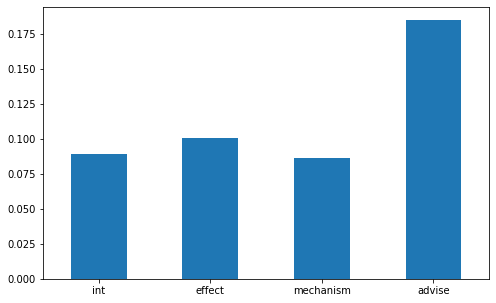

In [59]:
# e1 is uppercase
df1 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [int_counts_e1.index.str.isupper().sum()/int_counts_e1.shape[0],
                                                                            effect_counts_e1.index.str.isupper().sum()/effect_counts_e1.shape[0],
                                                                            mechanism_counts_e1.index.str.isupper().sum()/mechanism_counts_e1.shape[0],
                                                                            advise_counts_e1.index.str.isupper().sum()/advise_counts_e1.shape[0]]})

ax = df1.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False)
ax.set_xlabel("")

## Checking e2

Text(0.5, 0, '')

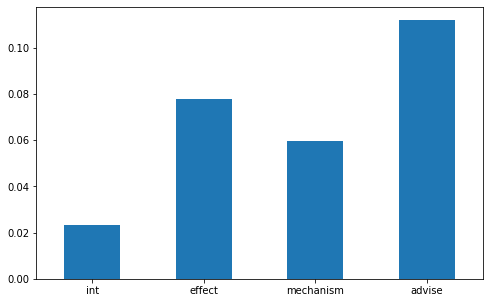

In [60]:
# e2 is uppercase
df1 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [int_counts_e2.index.str.isupper().sum()/int_counts_e2.shape[0],
                                                                            effect_counts_e2.index.str.isupper().sum()/effect_counts_e2.shape[0],
                                                                            mechanism_counts_e2.index.str.isupper().sum()/mechanism_counts_e2.shape[0],
                                                                            advise_counts_e2.index.str.isupper().sum()/advise_counts_e2.shape[0]]})

ax = df1.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False)
ax.set_xlabel("")